In [1]:
import pickle
import os

# Define the path for the model
MODEL_PATH = './model/best_model.pkl'

# Function to load the previous best model if it exists
def load_previous_model():
    if os.path.exists(MODEL_PATH):
        with open(MODEL_PATH, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {MODEL_PATH}")
        return model
    return None

def save_model(model):
    with open(MODEL_PATH, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved in {MODEL_PATH}")

## ÁRBOLES DE DECISIÓN – CLASIFICACIÓN BAYESIANA

## PUNTO 1

## **Descripción de los datos**
El conjunto de datos contiene información sobre el ausentismo laboral de empleados. Cada fila representa un registro de ausentismo con varias características (*features*) que pueden influir en la cantidad de horas de ausencia. Algunas de las principales características son:

- **Month of absence**: Mes en el que ocurrió la ausencia.
- **Day of the week**: Día de la semana en que ocurrió la ausencia.
- **Seasons**: Estación del año en que ocurrió la ausencia.
- **Transportation expense**: Gastos de transporte del empleado.
- **Distance from Residence to Work**: Distancia entre el hogar del empleado y el trabajo.
- **Service time**: Años de servicio del empleado.
- **Age**: Edad del empleado.
- **Work load Average/day**: Carga de trabajo promedio por día.
- **Disciplinary failure**: Indica si el empleado ha tenido fallas disciplinarias.
- **Education**: Nivel educativo del empleado.
- **Social drinker**: Indica si el empleado consume alcohol de forma social.
- **Social smoker**: Indica si el empleado fuma socialmente.
- **Body mass index (BMI)**: Índice de masa corporal del empleado.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)
df = pd.read_excel('Absenteeism_at_work.xls')
df.rename(columns={'Work load Average/day ':'Work load Average/day'}, inplace=True)
df.head()

ID  Reason for absence  Month of absence  Day of the week  Seasons  \
0  11                  26                 7                3        1   
1  36                   0                 7                3        1   
2   3                  23                 7                4        1   
3   7                   7                 7                5        1   
4  11                  23                 7                5        1   

   Transportation expense  Distance from Residence to Work  Service time  Age  \
0                     289                               36            13   33   
1                     118                               13            18   50   
2                     179                               51            18   38   
3                     279                                5            14   39   
4                     289                               36            13   33   

   Work load Average/day  Hit target  Disciplinary failure  Education  Son  \
0                 239554          97                     0          1    2   
1                 239554          97                     1          1    1   
2                 239554          97                     0          1    0   
3                 239554          97                     0          1    2   
4                 239554          97                     0          1    2   

   Social drinker  Social smoker  Pet  Weight  Height  Body mass index  \
0               1              0    1      90     172               30   
1               1              0    0      98     178               31   
2               1              0    0      89     170               31   
3               1              1    0      68     168               24   
4               1              0    1      90     172               30   

   Absenteeism time in hours  
0                          4  
1                          0  
2                          2  
3                          4  
4                          2

## **Contextualización del problema**
El objetivo del análisis es predecir la cantidad de tiempo que un empleado estará ausente basado en sus características personales y laborales. Para ello, se definió una clasificación basada en la columna **"Absenteeism time in hours"**, que es la variable objetivo (*target*):

1. **0** → No faltó.
2. **1** → Menos de un día (< 8 horas).
3. **2** → Menos de una semana (< 40 horas).
4. **3** → Más de una semana (> 40 horas).

## **Preprocesamiento realizado**
1. **Corrección de nombres de columnas**: Se eliminó el espacio extra en `"Work load Average/day "`.
2. **Creación de una nueva variable categórica**: Se transformó `"Absenteeism time in hours"` en la nueva columna `"clasificacion_abstinencia"`, que agrupa los valores en categorías más manejables.
3. **Eliminación de columnas redundantes**: Se eliminaron `"ID"`, `"Reason for absence"` y `"Absenteeism time in hours"`, ya que no aportan información relevante o son redundantes.

In [3]:
"""
no falto                0
menos de un dia         <8
menos de una semana     <40
mas de una semana       >40
"""

df["clasificacion_abstinencia"] = df["Absenteeism time in hours"].apply(
    lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 40 else 3
)
df = df.drop(
    columns=["ID", "Reason for absence", "Absenteeism time in hours"], errors="ignore"
)
df["clasificacion_abstinencia"].value_counts()

clasificacion_abstinencia
1    425
2    249
0     44
3     22
Name: count, dtype: int64

## **Análisis de la distribución de la variable objetivo**
El gráfico de barras muestra la cantidad de registros en cada una de las categorías de ausentismo. Se puede observar que la mayoría de los empleados faltan entre un dia y una semana, mientras que los casos de ausentismo prolongado mayores a una semana son menos frecuentes. Tambien son muy pocas las personas que no faltaron ni una sola vez. Como se observa en la siguiente grafica, las clases estan desbalanceadas y hay que tener esto en cuenta para entrenar el modelo mas adelante.

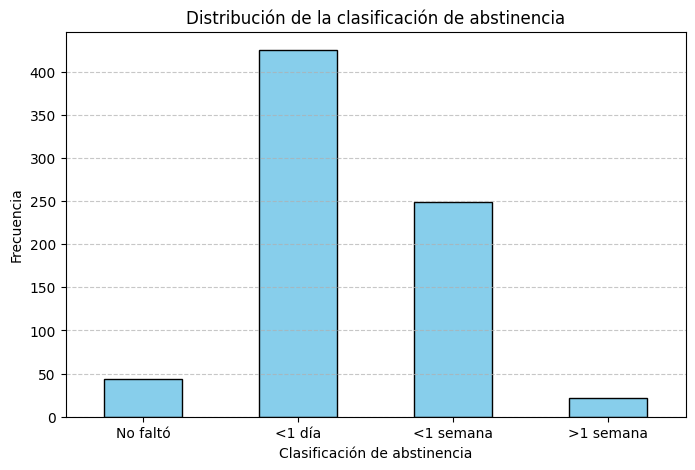

In [4]:
import pandas as pd

df = pd.read_excel('Absenteeism_at_work.xls')

df.rename(columns={'Work load Average/day ': 'Work load Average/day'}, inplace=True)

df["clasificacion_abstinencia"] = df["Absenteeism time in hours"].apply(
    lambda x: 0 if x == 0 else 1 if x < 8 else 2 if x < 40 else 3
)

df = df.drop(columns=["ID", "Reason for absence", "Absenteeism time in hours"], errors="ignore")

clasificacion_counts = df["clasificacion_abstinencia"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
clasificacion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xticks(ticks=[0, 1, 2, 3], labels=["No faltó", "<1 día", "<1 semana", ">1 semana"], rotation=0)
plt.xlabel("Clasificación de abstinencia")
plt.ylabel("Frecuencia")
plt.title("Distribución de la clasificación de abstinencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Análisis

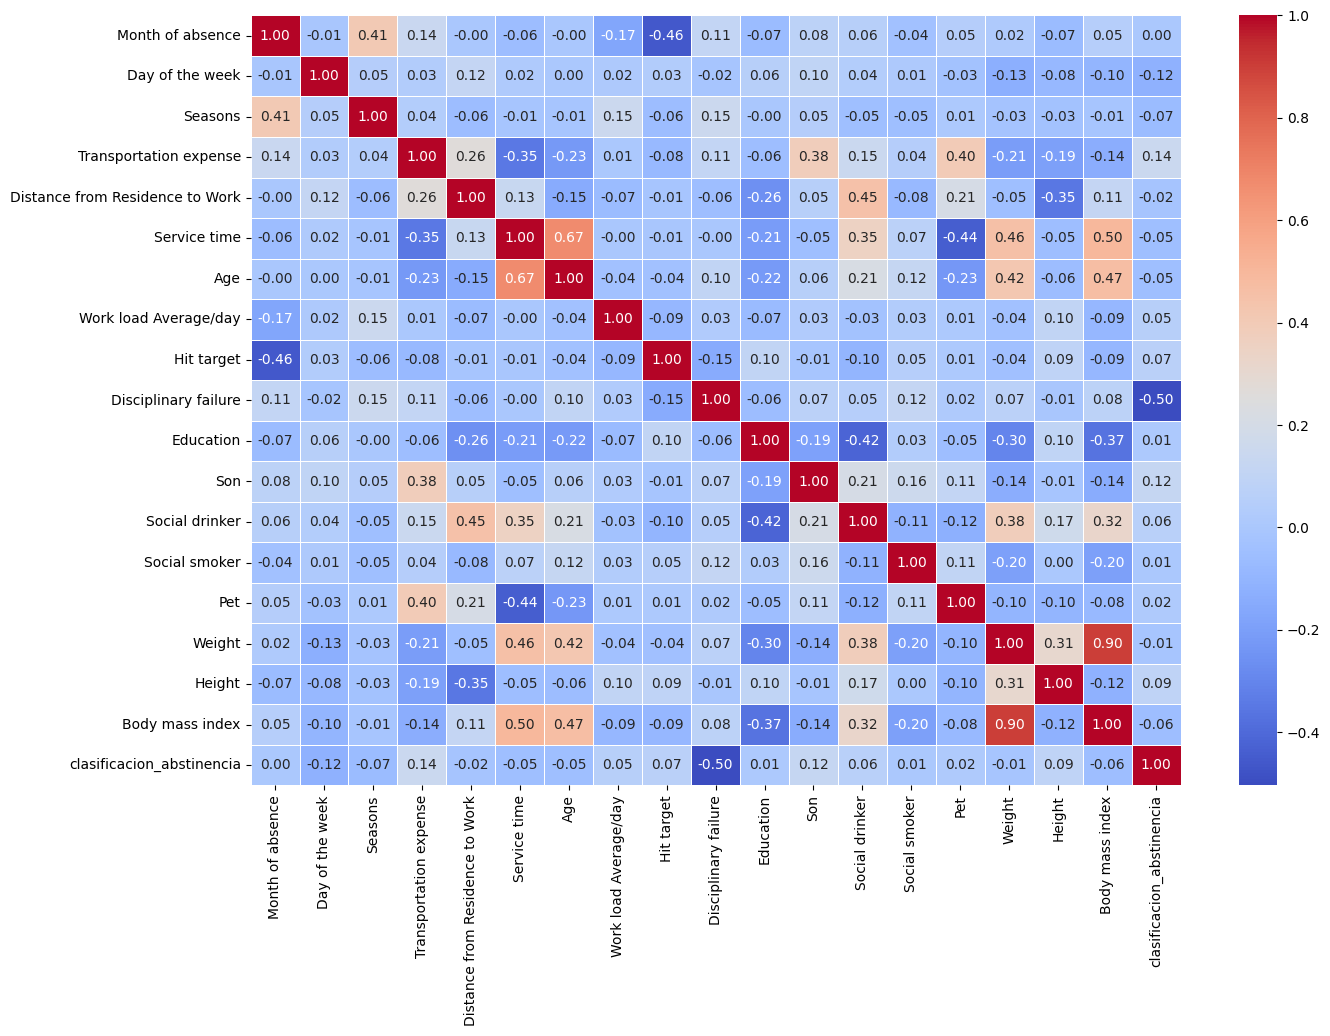

In [5]:
import seaborn as sns
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5);

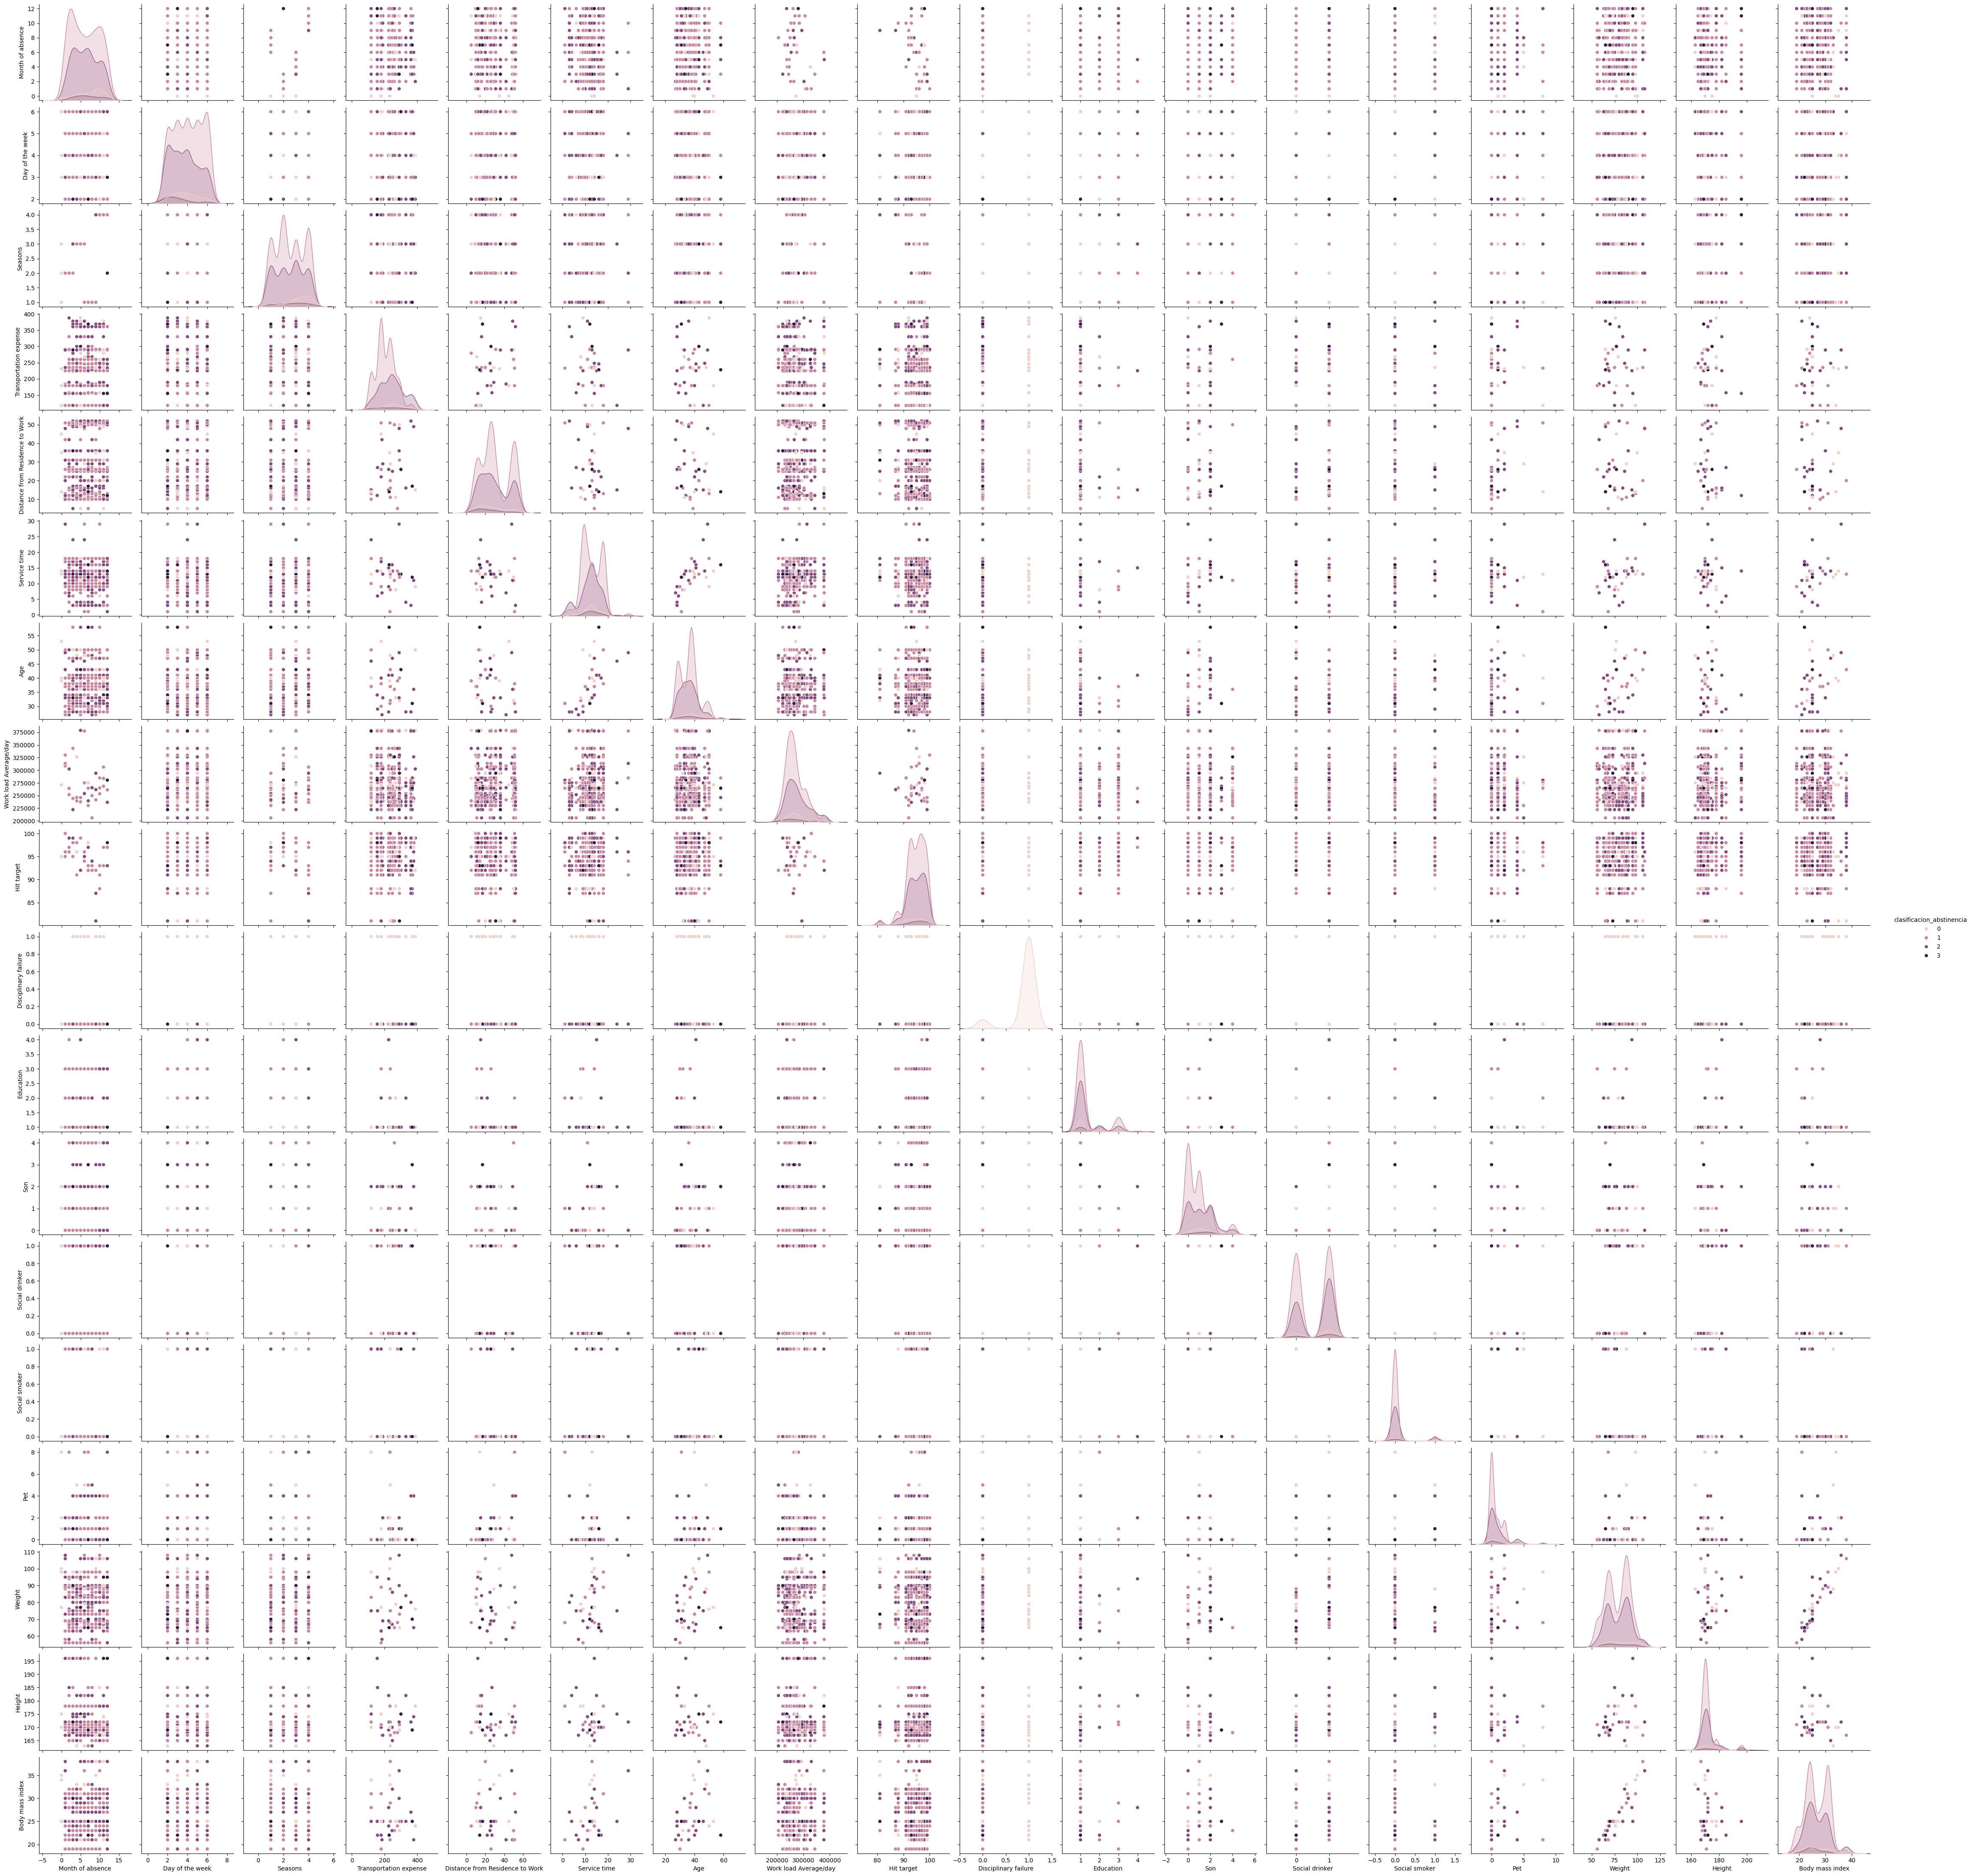

In [20]:
sns.pairplot(df, hue="clasificacion_abstinencia");

### **Diferentes profundidades del árbol**
Se probo poner el limete maximo de profundidad del arbol en un rango de vales entre 1 y la cantidad de atributos del dataset (19). Se uso un cross-validator para asi obtener una estimación más robusta del desempeño real del modelo

In [7]:
from sklearn.model_selection import KFold
from sklearn import tree

cv = KFold(n_splits=20) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(df))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
  # X = df.drop(columns=["clasificacion_abstinencia"])
  # y = df["clasificacion_abstinencia"]

  fold_accuracy = []
  tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
  
  for train_fold, valid_fold in cv.split(df):
    f_train = df.loc[train_fold]
    f_valid = df.loc[valid_fold]

    naive_bayes_classifier = tree_model.fit(X = f_train.drop(columns=["clasificacion_abstinencia"]),
                           y = f_train["clasificacion_abstinencia"])
    valid_acc = naive_bayes_classifier.score(X = f_valid.drop(columns=["clasificacion_abstinencia"]),
                            y = f_valid["clasificacion_abstinencia"])
    fold_accuracy.append(valid_acc)
  
  avg = sum(fold_accuracy)/len(fold_accuracy)
  accuracies.append(avg)

# Mostramos los resultados obtenidos
dataframe = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
dataframe = dataframe[["Max Depth", "Average Accuracy"]]
print(dataframe.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.509459
         2          0.206757
         3          0.410811
         4          0.475676
         5          0.482432
         6          0.497297
         7          0.532432
         8          0.556757
         9          0.591892
        10          0.602703
        11          0.598649
        12          0.602703
        13          0.598649
        14          0.601351
        15          0.597297
        16          0.601351
        17          0.598649
        18          0.601351
        19          0.597297


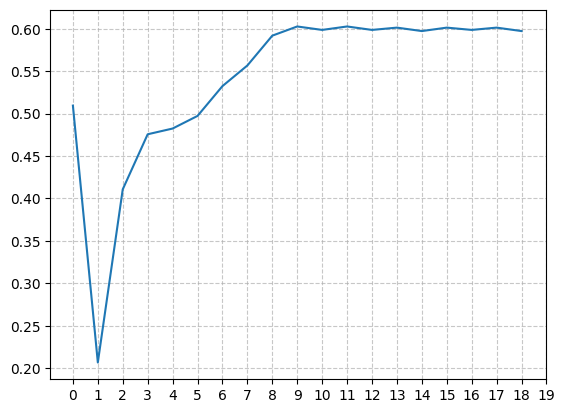

In [21]:
dataframe["Average Accuracy"].plot()
plt.xticks(list(range(0, max_attributes + 1)))
plt.grid(linestyle='--', alpha=0.7)

Dentro de los valores de 8 y 10 obtenemos los mejores valores de accuracy. Podemos ver que despues de 10 el accuracy se mantiene constante, por lo que no tiene sentido seguir aumentando la profundidad del arbol.

## PUNTO 2
Entrenamiento del modelo usando GridSearchCV para encontrar los mejores hiperparámetros de SelectKBest y DecisionTreeClassifier. Se usaron 10 folds para la validación cruzada.

### DT Entrenamiento

In [22]:
from joblib import Memory

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.tree import DecisionTreeClassifier

# Cache
memory = Memory(location="./pipeline_cache", verbose=0)

pipeline = Pipeline(
    steps=[
        ("feature_selection", SelectKBest(score_func=f_classif)),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ],
    memory=memory
)

## **Justificación del nodo raíz y nodos hijo**
- El **nodo raíz** del árbol de decisión se selecciona en función de la característica que maximiza la ganancia de información (para Entropía) o minimiza la impureza (para Gini).
- Se analizaron las **importancias de las características**, y se puede observar cuáles son las variables más relevantes para la clasificación de la ausencia.
- Las características con mayor importancia en ambos métodos son claves para entender qué factores influyen más en el ausentismo.


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = df.drop(columns=["clasificacion_abstinencia"])
y = df["clasificacion_abstinencia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
param_grid = {
"feature_selection__k": range(1, 10),
"feature_selection__score_func": [f_classif, chi2],
"classifier__criterion": ["gini", "entropy"],
"classifier__max_depth": range(1, 10),
"classifier__min_samples_split": range(2, 10),
"classifier__min_samples_leaf": range(1, 10),
"classifier__class_weight": ["balanced", None]
}

current_model = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=10, scoring="balanced_accuracy")

current_model.fit(X_train, y_train)

In [22]:
current_model = load_previous_model() or current_model

Model loaded from ./model/best_model.pkl


**Entropía** es un mejor criterio en este caso, ya que logra una mejor separación de las clases y obtiene mayor precisión.

## PUNTO 3

El porcentaje de datos utilizados para **entrenamiento fue del 80%** y para **pruebas fue del 20%**. En la mayoría de casos es una medida de elección común, depeniendo de factores como la cantidad de datos disponibles y el tipo de problemas que se esten resolviendo. Aunque el dataset utilizado tiene un total de 740 datos, es un dataset pequeño, tener esta muestra suele ser suficiente para obtener una estimación confiable del desempeño del modelo sin comprometer la calidad del entrenamiento.



In [23]:
current_model.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 5,
 'feature_selection__k': 4,
 'feature_selection__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

In [24]:
best_selector = current_model.best_estimator_.named_steps["feature_selection"]
best_classifier = current_model.best_estimator_.named_steps["classifier"]

Mejores 4 caracteristicas escogidas por SelectKBest

In [33]:
for feature, score in zip(
    X.columns[best_selector.get_support()],
    best_selector.scores_[best_selector.get_support()],
):
    print(f"{feature}: {score:.2f}")

Day of the week: 7.23
Transportation expense: 13.80
Disciplinary failure: 3042.80
Son: 8.85


Disciplinary failure es con diferencia la caracteristica mas importante para el modelo, luego le siguen en importancia las variables de Transportation expense, Son y Day of the week.

### Importancia de las características para el modelo

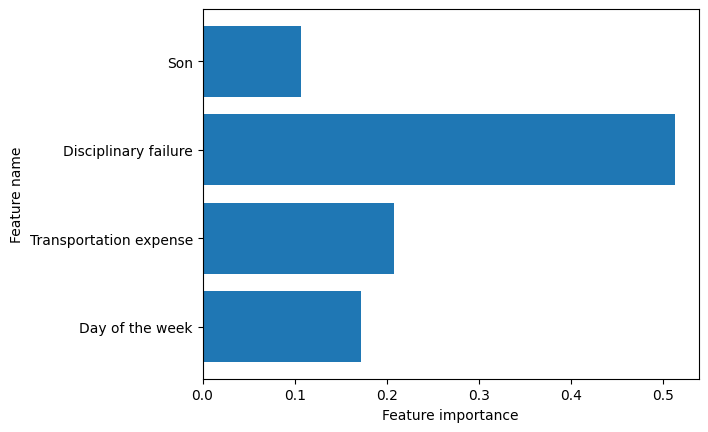

In [28]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

feature_names = X.columns[best_selector.get_support()]
plot_feature_importances(best_classifier, feature_names)

## Arbol graficado

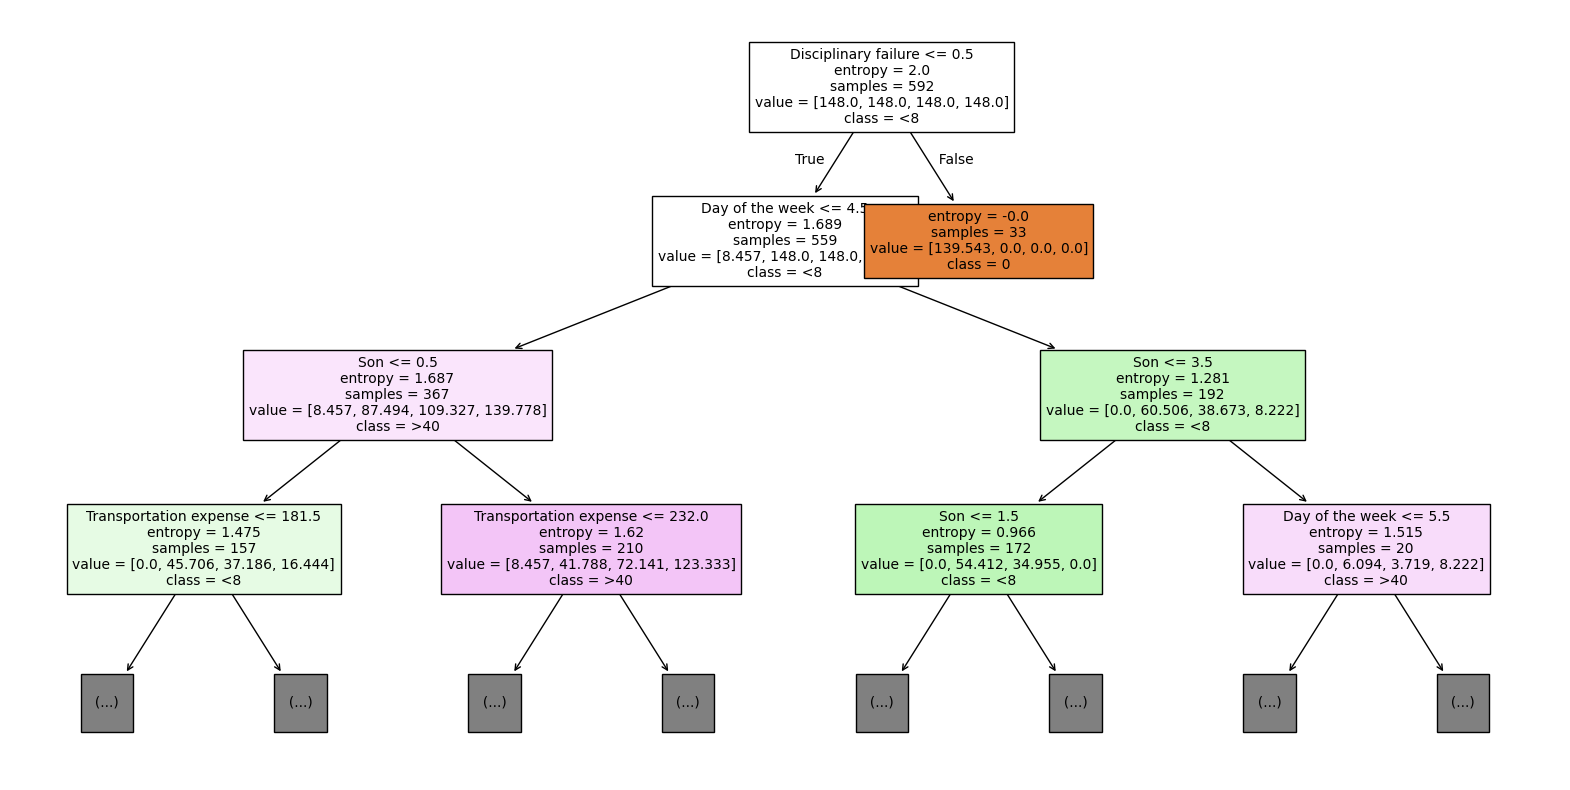

In [35]:
from sklearn import tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_classifier, feature_names=feature_names, filled=True, fontsize=10, max_depth=3, class_names=["0", "<8", "<40", ">40"]);

## PUNTO 6
- Para determinar la cantidad de mínima de muestras por nodo, se determino que el conjunto de datos es pequeño y por consiguiente **5 muestras** por nodo eran suficientes para permitir que el árbol explore las divisiones con suficientes datos. En el caso del mínimo de muestras por hoja se selecciono el tamaño de **1 muestra** por ser un problema simple con un origen de datos con pocos registros. Adicionalmente, las clases se determinaron estos valores por el desbalanceo presentado en las clases y para obtener un entrenamiento más general.

### Exactitud para diferentes valores

- Dado que los mejores parámetros encontrados por GridReachCV fueron:
-- classifier__min_samples_leaf (mínimo de muestras por hoja): 1
-- classifier__min_samples_split (mínimo de muestras por nodo): 5

In [1]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Exactitud del Árbol de Decisión:")
print(f"Exactitud del árbol de decisión en conjunto de prueba: {accuracy_score(y_test, current_model.predict(X_test)):.4f}")
print(f"Exactitud del árbol de decisión en conjunto de entrenamiento: {accuracy_score(y_train, current_model.predict(X_train)):.2f}")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from supertree import SuperTree

super_tree = SuperTree(
    model=best_classifier,
    feature_data=X_train[feature_names],
    target_data=y.values,
    feature_names=feature_names.tolist(),
    target_names=["0", "1", "2", "3"],
)
super_tree.show_tree(start_depth=8)

### Puntaje del modelo DecisionTree
Puntaje del DecisionTreeClassifier usando los mejores parametros encontrados por GridSearchCV
```json
{
 "classifier__class_weight": "balanced",
 "classifier__criterion": "entropy",
 "classifier__max_depth": 8,
 "classifier__min_samples_leaf": 1,
 "classifier__min_samples_split": 5,
 "feature_selection__k": 4,
 "feature_selection__score_func": "f_classif"
}
```

**Fue necesario balancear** los parámetros del modelo y manipular los datos para garantizar que el modelo no se vea afectado por las clases 0(No falto) y 3(Falto más de 40 horas) que presentan un menor número de datos que las otras clases.

In [23]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Exactitud del Árbol de Decisión:")
print(f"Exactitud del árbol de decisión en conjunto de prueba: {accuracy_score(y_test, current_model.predict(X_test)):.4f}")
print(f"Exactitud del árbol de decisión en conjunto de entrenamiento: {accuracy_score(y_train, current_model.predict(X_train)):.2f}")

print("\nExactitud balanceada:")
print(f"Exactitud balanceada del árbol de decisión en conjunto de prueba: {balanced_accuracy_score(y_test, current_model.predict(X_test)):.4f}")
print(f"Exactitud balanceada del árbol de decisión en conjunto de entrenamiento: {balanced_accuracy_score(y_train, current_model.predict(X_train)):.2f}")

Exactitud del Árbol de Decisión:
Exactitud del árbol de decisión en conjunto de prueba: 0.6216
Exactitud del árbol de decisión en conjunto de entrenamiento: 0.67

Exactitud balanceada:
Exactitud balanceada del árbol de decisión en conjunto de prueba: 0.6233
Exactitud balanceada del árbol de decisión en conjunto de entrenamiento: 0.80


In [15]:
from sklearn.metrics import classification_report
print("Reporte de clasificación - Conjunto de prueba:")
print(classification_report(y_test, current_model.predict(X_test), target_names=["No faltó", "<1 día", "<1 semana", ">1 semana"]))
print("\nReporte de clasificación - Conjunto de entrenamiento:")
print(classification_report(y_train, current_model.predict(X_train), target_names=["No faltó", "<1 día", "<1 semana", ">1 semana"]))

Reporte de clasificación - Conjunto de prueba:
              precision    recall  f1-score   support

    No faltó       0.70      0.78      0.74         9
      <1 día       0.75      0.64      0.69        85
   <1 semana       0.71      0.58      0.64        50
   >1 semana       0.08      0.50      0.14         4

    accuracy                           0.62       148
   macro avg       0.56      0.62      0.55       148
weighted avg       0.71      0.62      0.66       148


Reporte de clasificación - Conjunto de entrenamiento:
              precision    recall  f1-score   support

    No faltó       0.85      1.00      0.92        35
      <1 día       0.85      0.65      0.74       340
   <1 semana       0.69      0.62      0.65       199
   >1 semana       0.15      0.94      0.26        18

    accuracy                           0.67       592
   macro avg       0.64      0.80      0.64       592
weighted avg       0.78      0.67      0.70       592



matrix de confusion

Casos de test: 148
Casos de entrenamiento: 592


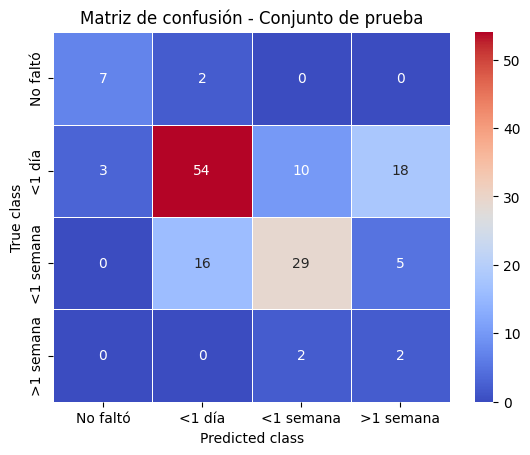

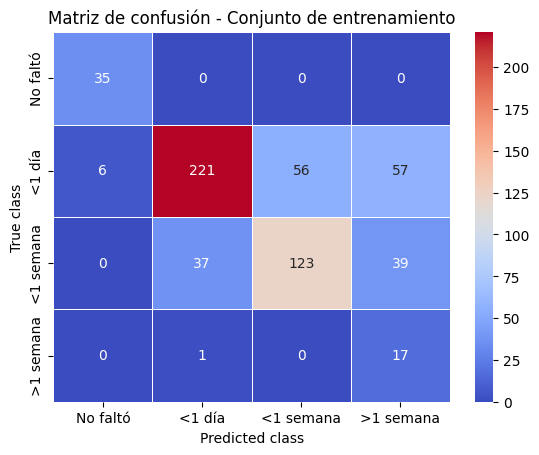

In [22]:
# matrix de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns

print(f"Casos de test: {y_test.size}")
conf_matrix = confusion_matrix(y_test, current_model.predict(X_test))
plt.figure()
plt.title("Matriz de confusión - Conjunto de prueba")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, xticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"], yticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"])
plt.xlabel("Predicted class")
plt.ylabel("True class")

print(f"Casos de entrenamiento: {y_train.size}")
conf_matrix = confusion_matrix(y_train, current_model.predict(X_train))
plt.figure()
plt.title("Matriz de confusión - Conjunto de entrenamiento")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, xticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"], yticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"])
plt.xlabel("Predicted class")
plt.ylabel("True class");

#### Analisis de resultados - Arbol de decision

1. Hay un gran desbalance de clases: La clase >1 semana es muy pequeña y por eso hay muchos Falsos positivos (precision=0.08). Sin embarco, apesar de eso, el 50% de los casos positivos fueron predichos correctamente

2. La clase mejor predicha fue la <1 dia, lo cual es de esperarse pues es la que mas datos de entrenamiente tiene

3. Apesar de que la clase "No falto" tiene muchos menos ejemplos que la clase "<1 semana", tubieron una precision muy similar. Esto indica que la clase "No falto" es muy diferente al resto y es mas facil de predecir.

4. Cuando hacemos predicciones usando los mismo datos con que fue entrenado el modelo, vemos que se equivoca considerablemente, esto lo hacemos para comprobar que el modelo no este sobreajustado.

# Clasificacion bayesiana

In [75]:
# naive bayes classifier
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)
naive_bayes_classifier

GaussianNB()

## Puntaje del modelo naive de bayes

In [80]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

print("Exactitud del Clasificador Naive Bayes:")
print(f"Exactitud del clasificador Naive Bayes en conjunto de prueba: {accuracy_score(y_test, naive_bayes_classifier.predict(X_test)):.2f}")
print(f"Exactitud del clasificador Naive Bayes en conjunto de entrenamiento: {accuracy_score(y_train, naive_bayes_classifier.predict(X_train)):.2f}")

print("\nExactitud balanceada:")
print(f"Exactitud balanceada del clasificador Naive Bayes en conjunto de prueba: {balanced_accuracy_score(y_test, naive_bayes_classifier.predict(X_test)):.2f}")
print(f"Exactitud balanceada del clasificador Naive Bayes en conjunto de entrenamiento: {balanced_accuracy_score(y_train, naive_bayes_classifier.predict(X_train)):.2f}")

Exactitud del Clasificador Naive Bayes:
Exactitud del clasificador Naive Bayes en conjunto de prueba: 0.64
Exactitud del clasificador Naive Bayes en conjunto de entrenamiento: 0.63

Exactitud balanceada:
Exactitud balanceada del clasificador Naive Bayes en conjunto de prueba: 0.39
Exactitud balanceada del clasificador Naive Bayes en conjunto de entrenamiento: 0.45


In [81]:
from sklearn.metrics import classification_report
print("Classification report test:")
print(classification_report(y_test, naive_bayes_classifier.predict(X_test), target_names=["No faltó", "<1 día", "<1 semana", ">1 semana"]))
print("Classification report entrenamiento:")
print(classification_report(y_train, naive_bayes_classifier.predict(X_train), target_names=["No faltó", "<1 día", "<1 semana", ">1 semana"]))

Classification report test:
              precision    recall  f1-score   support

    No faltó       0.43      0.33      0.38         9
      <1 día       0.70      0.86      0.77        85
   <1 semana       0.60      0.36      0.45        50
   >1 semana       0.00      0.00      0.00         4

    accuracy                           0.64       148
   macro avg       0.43      0.39      0.40       148
weighted avg       0.63      0.64      0.62       148

Classification report entrenamiento:
              precision    recall  f1-score   support

    No faltó       0.36      0.23      0.28        35
      <1 día       0.69      0.83      0.76       340
   <1 semana       0.59      0.39      0.47       199
   >1 semana       0.20      0.33      0.25        18

    accuracy                           0.63       592
   macro avg       0.46      0.45      0.44       592
weighted avg       0.62      0.63      0.62       592



### Matrix de confusion

Casos de test: 148
[  7 105  30   6]
Casos de entrenamiento: 592
[ 22 409 131  30]


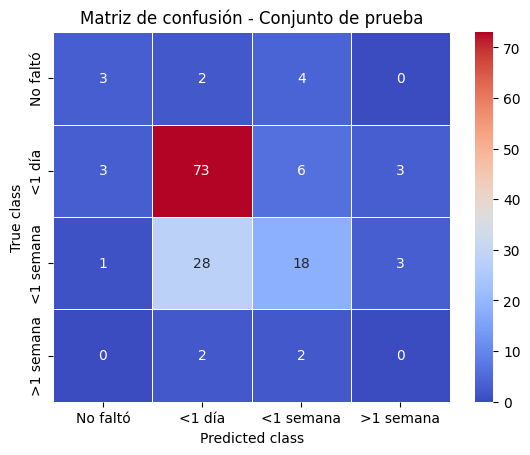

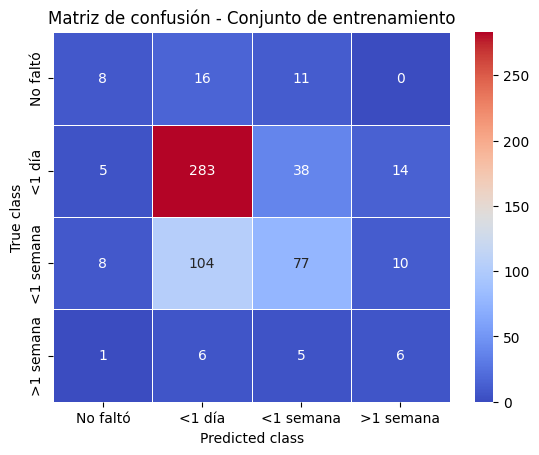

In [44]:
print(f"Casos de test: {y_test.size}")
conf_matrix = confusion_matrix(y_test, naive_bayes_classifier.predict(X_test))
print(conf_matrix.sum(axis=0))
plt.figure()
plt.title("Matriz de confusión - Conjunto de prueba")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, xticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"], yticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"])
plt.xlabel("Predicted class")
plt.ylabel("True class")

print(f"Casos de entrenamiento: {y_train.size}")
conf_matrix = confusion_matrix(y_train, naive_bayes_classifier.predict(X_train))
print(conf_matrix.sum(axis=0))
plt.figure()
plt.title("Matriz de confusión - Conjunto de entrenamiento")
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, xticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"], yticklabels=["No faltó", "<1 día", "<1 semana", ">1 semana"])
plt.xlabel("Predicted class")
plt.ylabel("True class");

### Analisis de resultados - Clasificacion bayeasiana

1. El accuracy_score fue de 0.64, parece un buen resultado, sin embargo, si vemos el balanced_accuracy_score nos dio 0.39, esto quiere decir que el modelo solo esta prediciendo la clase mayoritaria en la mayoria de los casos y no esta ignorando las clases minoritarias.

2. La clase ">1 semana" no la predijo bien ni usa sola vez en los datos de entrenamiento. Esto en parte es causado por la baja cantidad de muestras de esta clase y lo mal balanceado que estan los datos.

3. Los datos no parecen estar sobreajustados pues aun probando el modelo con los mismo datos que se entreno los resultados siguen siendo malos

4. El modelo sufre de **underfitting** ya que es demasiado simple para representar los datos de entrenamiento, esto se puede ver en el accuracy_score y el balanced_accuracy_score, ambos valores son bajos.

# Conclusiones Generales

- El Arbol de decision con los mejores parametros del GridSearchCV dio un balanced_accuracy_score de 0.6233
- Gaussian Naive Bayes dio un balanced_accuracy_score de 0.39

Con esto, mas todos los analisis dichos anteriormente, podemos decir con seguridad que **lo mejor es usar un arbol de prediccion** con los siguientes parametros:

```json
{
 "classifier__class_weight": "balanced",
 "classifier__criterion": "entropy",
 "classifier__max_depth": 8,
 "classifier__min_samples_leaf": 1,
 "classifier__min_samples_split": 5,
 "feature_selection__k": 4,
 "feature_selection__score_func": "f_classif"
}
```

los mas importantes a destacar es usar el **criterio de entropy**, con una **profundidad maxima de 8** para asi no sobreajustar y usar **class_weight="balanced"** para darle mas importancia a las clases minoritarias.

A la hora de seleccionar las caracteristicas con **SelectKBest** para predecir lo mejor fue usar **4 caracteristicas** junto con **f_classif**.

Con esta combinacion se logro predeccir correctamente en el 62.33% de los intentos.